In [1]:
#Import all the required libraries
import time
import re
import glob
from time import sleep
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import random
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import socket
import pickle5 as pickle
import os

In [2]:
from common.constants import test, BoxField, DatasetField
from common.config import Config
from common.logger import Logger
from common.communication import Client
from common.communication import Server
from common.helper import ImagesInfo 
from common.timekeeper import TimeKeeper
from common.helper import read_image, filt_text, get_predictions,process_predictions, get_reshape_size
from CaptionModel import CaptionModel

In [3]:
# h_image_height = 150
h_image_height = 200
# max_tokenized_words = 5000
max_tokenized_words = 5000
# test_files_num = 118287
# test_files_num = 10000
test_files_num = 15

h_cap_feature_size = get_reshape_size(h_image_height)

In [4]:
in_nimble = False
in_WSL = False
in_gcp = False

host = socket.gethostname()
if('cuda' in host):
    in_nimble = True
    print("In NimbleBox")
if(host == 'LTsuphale-NC2JM'):
    in_WSL = True
    print("In WSL")
if(host == 'instance-1'):
    in_gcp = True
    print("In GCP")
    
    

In WSL


In [5]:
images_path = ''
text_file = ''


if(in_WSL == True):
    images_path='/home/suphale/snehal_bucket/coco/raw-data/train2017/'
    text_file = '/home/suphale/WorkSpace/lists/captions_' + str(118287) +'.txt'
    list_file = '/home/suphale/WorkSpace/lists/images_' + str(118287) +'.txt'
if(in_nimble == True):
    images_path='/mnt/disks/user/project/coco/train2017/'
    text_file = '/mnt/disks/user/project/WorkSpace/lists/captions_' + str(test_files_num) +'.txt'
    list_file = '/mnt/disks/user/project/WorkSpace/lists/images_' + str(test_files_num) +'.txt'
if(in_gcp == True):
    images_path='/home/suphale/coco/train2017/'
    text_file = '/home/suphale/WorkSpace/lists/captions_' + str(test_files_num) +'.txt'
    list_file = '/home/suphale/WorkSpace/lists/images_' + str(test_files_num) +'.txt'

# Find out total number of images in the images folder
all_imgs_folder = glob.glob(images_path + '/*.jpg',recursive=True)
all_imgs_folder = sorted(all_imgs_folder)
total_num_images_folder = len(all_imgs_folder)
print("The total images present in the images folder: {}".format(total_num_images_folder))


The total images present in the images folder: 118287


In [6]:
file = open(list_file, 'r')
count = 0
all_imgs = []
for line in file:
    count += 1
    # print("Line{}: {}".format(count, line.strip()))
    all_imgs.append(line.rstrip())
    if(count > test_files_num):
        break
file.close()

all_imgs = sorted(all_imgs)
total_num_images = len(all_imgs)
print("The total images present in the dataset: {}".format(total_num_images))



The total images present in the dataset: 16


In [7]:
#Visualise both the images & text present in the dataset
print("The total images present in the dataset: {}".format(total_num_images))
num_lines = sum(1 for line in open(text_file))
print("The total number of lines in the caption file: {}".format(num_lines))



The total images present in the dataset: 16
The total number of lines in the caption file: 594145


In [8]:
# define a function to clean text data
def extract_jpg_caption(line):
    char_filter = r"[^\w]"

    jpg_path = None
    caption = None

    jpg_position = line.find(".jpg")
    if(jpg_position != -1):
        jpg_path = images_path + '/' + line[:jpg_position+4]

        caption = line[jpg_position+5:].strip()

        # convert words to lower case
        caption = caption.lower()

        # split into words
        words = caption.split()

        # strip whitespace from all words
        words = [word.strip() for word in words]

        # join back words to get document
        caption = " ".join(words)

        # remove unwanted characters
        caption = re.sub(char_filter, " ", caption)

        # remove unwanted characters
        caption = re.sub(r"\.", " ", caption)

        # replace multiple whitespaces with single whitespace
        caption = re.sub(r"\s+", " ", caption)

        # strip whitespace from document
        caption = caption.strip()

        caption = '<start> ' + caption + ' <end>'

    return jpg_path, caption

In [9]:
#store all the image id here
all_img_id= [] 
#store all the image path here
all_img_vector=[]
#store all the captions here
annotations= [] 
# list of all captions in word list format
annotations_word_list = []

In [10]:
def load_doc(filename):
    #your code here
    file  = open(filename, 'r') 
    Lines = file.readlines() 
    
    text = ""
    count = 0
    for line in Lines:
        jpg_path, caption = extract_jpg_caption(line)
        if(jpg_path != None):
            all_img_id.append(count)
            all_img_vector.append(jpg_path)
            annotations.append(caption)
            word_list = caption.split()
            annotations_word_list.append(word_list)
            text += " " + caption
            count += 1
            if(count > total_num_images*6):
                break
    file.close()
    return text

In [11]:
#Import the dataset and read the text file into a seperate variable
doc = load_doc(text_file)


In [12]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))
total_images = len(all_img_vector)

Total captions present in the dataset: 97
Total images present in the dataset: 97


In [13]:
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

In [14]:
# create the tokenizer

# your code here
# max_tokenized_words = 20000

tokenizer = Tokenizer(num_words=max_tokenized_words+1,oov_token='<unknown>')
tokenizer.fit_on_texts(annotations_word_list)


In [15]:
# Create word-to-index and index-to-word mappings.
VOCABULARY_SIZE = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(VOCABULARY_SIZE))


Vocabulary Size: 295


In [16]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

MAX_SEQ_LENGTH = 25

cap_vector = annotations_word_list
Y_encoded = tokenizer.texts_to_sequences(cap_vector)
cap_vector_encoded_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")


In [17]:
#write your code here
batch_size = 32
def read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image_height = tf.shape(image)[0]
    image = tf.image.resize(image, (h_image_height, h_image_height))
#     image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, label


In [18]:
from sklearn.model_selection import train_test_split

# split the data into train, validation and final test sets
img_train, final_img_test, cap_train, final_cap_test = train_test_split(all_img_vector, cap_vector_encoded_padded, test_size=0.01, random_state=42)
img_train, img_test, cap_train, cap_test = train_test_split(img_train, cap_train, test_size=0.2, random_state=42)

total_training_images = len(img_train)
total_test_images = len(img_test)
total_final_testing_images = len(final_img_test)
print("Total Images for training=%d" % (total_training_images))
print("Total Images for testing (validation)=%d" % (total_test_images))
print("Total Images for final random testing=%d" % (total_final_testing_images))

Total Images for training=76
Total Images for testing (validation)=20
Total Images for final random testing=1


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((final_img_test, final_cap_test))


In [20]:
#write your code here
train_dataset = train_dataset.map(read_image)
train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(read_image)
test_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


A utility function to display image retrieved from a dataset and its corresponding caption

In [21]:
# A utility function to display image retrieved from a dataset and its corresponding caption
def show_image_caption_from_dataset(image,label):
    plt.imshow(image)
    for x in label.numpy():
        if(x != 0):
            print(tokenizer.index_word[x], end =" ")


In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# write code here to get the input of the image_model
new_input = image_model.input 
# write code here to get the output of the image_model
hidden_layer = image_model.output 

#build the final model using both input & output layer
image_features_extract_model = keras.Model(inputs=new_input, outputs=hidden_layer)

In [23]:
# write your code to extract features from each image in the dataset
def extract_image_features(sample_img_batch):
    features = image_features_extract_model(sample_img_batch)
    features = tf.reshape(features, [sample_img_batch.shape[0],h_cap_feature_size*h_cap_feature_size, 2048])
    return features


In [24]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
sample_img_batch = extract_image_features(sample_img_batch)


In [25]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
sample_img_batch = extract_image_features(sample_img_batch)


In [26]:
embedding_dim = 256 
units = 512
vocab_size = max_tokenized_words + 1
train_num_steps = total_training_images //batch_size #len(total train images) // BATCH_SIZE
test_num_steps = total_test_images //batch_size #len(total test images) // BATCH_SIZE

### Encoder

In [27]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # build your Dense layer with relu activation
#         self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
#         features = tf.expand_dims(features, 0) 
#         features = self.pooling(features)
        features = self.dense(features)
        return features    

In [28]:
encoder=Encoder(embedding_dim)

### Attention model

In [29]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.activations import softmax

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.units=units
        # build your Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)
        # build your final Dense layer with unit 1
        # self.V = tf.keras.layers.Dense(1, activation='softmax')
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        score = self.V(score)
        attention_weights = softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.reduce_mean(context_vector, axis=1)

        return context_vector, attention_weights        

### Decoder

In [30]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. 
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [31]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [32]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (20, 16, 256)
Predcitions shape from Decoder: (20, 5001)
Attention weights shape from Decoder: (20, 16, 1)


In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [34]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [35]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [37]:
# @tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    img_tensor = extract_image_features(img_tensor)

    with tf.GradientTape() as tape:
        # Get the fixed length vector of Encoder-Decoder model
        features = encoder(img_tensor)
        # Loop through for max_length times
        for i in range(1, target.shape[1]):
            # Get predictions from the decoder
            #print("dec_input=%s features=%s hidden=%s" % (str(type(dec_input)), str(type(features)), str(type(hidden))))
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # Get the next target vector as dec_input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [38]:
# @tf.function
def test_step(img_tensor, target):
    #write your code here to do the testing steps
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    img_tensor = extract_image_features(img_tensor)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [39]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [40]:
loss_plot = []
test_loss_plot = []
EPOCHS = 5

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    

    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 20%|██        | 1/5 [00:14<00:57, 14.26s/it]

For epoch: 1, the train loss is 5.963, & test loss is inf
Time taken for 1 epoch 14.260626554489136 sec



 40%|████      | 2/5 [00:26<00:38, 12.79s/it]

For epoch: 2, the train loss is 5.142, & test loss is inf
Time taken for 1 epoch 11.75792407989502 sec



 60%|██████    | 3/5 [00:39<00:25, 12.90s/it]

For epoch: 3, the train loss is 3.686, & test loss is inf
Time taken for 1 epoch 13.033720254898071 sec



 80%|████████  | 4/5 [00:51<00:12, 12.63s/it]

For epoch: 4, the train loss is 3.272, & test loss is inf
Time taken for 1 epoch 12.197125434875488 sec



100%|██████████| 5/5 [01:03<00:00, 12.77s/it]

For epoch: 5, the train loss is 3.339, & test loss is inf
Time taken for 1 epoch 12.5645112991333 sec



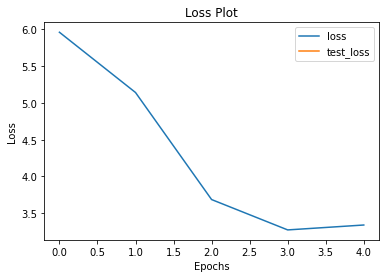

In [41]:
plt.plot(loss_plot,label="loss")
plt.plot(test_loss_plot,label="test_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(loc="upper right")
plt.show()

In [42]:
def evaluate(image):
    attention_features_shape = h_cap_feature_size * h_cap_feature_size
    attention_plot = np.zeros((MAX_SEQ_LENGTH, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(read_image(image,[])[0], 0) 
    # Extract features using our feature extraction model
    img_tensor_val = extract_image_features(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_SEQ_LENGTH):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(tf.transpose(predictions))
        predicted_id = predicted_id.numpy()[0]
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [43]:
def beam_evaluate(image, beam_index = 0): #your value for beam index):

    final_caption = "ToDo"
    #write your code to evaluate the result using beam search
                  
    return final_caption


In [44]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (h_cap_feature_size,h_cap_feature_size))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot((len_cap//2)+1, (len_cap//2)+1, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [45]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

Time elapsed:  0.784079400000337
BLEU score: 4.166666666666666
Real Caption: a commercial dish washing station with a toilet in it
Prediction Caption: with with with with with with with with with with with with with with with with with with with with with with with with


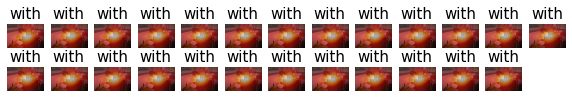

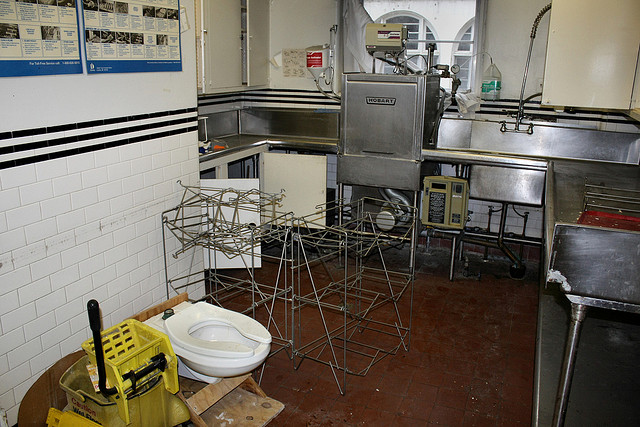

In [46]:
import time
rid = np.random.randint(0, total_final_testing_images)
test_image = final_img_test[rid]
# test_image = './Images/413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

real_caption = final_cap_test[rid]
# real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [47]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [48]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
attention_model (Attention_m multiple                  394753    
_________________________________________________________________
embedding (Embedding)        multiple                  1280256   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_4 (Dense)              multiple                  262656    
_________________________________________________________________
dense_5 (Dense)              multiple                  2565513   
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_________________________________________________________________


In [49]:
import os
# saving
temp_dir = 'temp/i_%d' % (h_image_height)
try: 
    os.mkdir(temp_dir) 
except OSError as error: 
    print(error)  
with open(temp_dir + '/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#decoder.save('MyModel',save_format='tf')
model_json = image_features_extract_model.to_json()
with open(temp_dir + "/image_features_extract_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
image_features_extract_model.save_weights(temp_dir + "/image_features_extract_model.h5")
print("Saved image_features_extract_model to disk")

decoder.save_weights(temp_dir + "/decoder.h5")
encoder.save_weights(temp_dir + "/encoder.h5")


Saved image_features_extract_model to disk


In [50]:
#Reading the model from JSON file
with open(temp_dir + '/image_features_extract_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights(temp_dir + '/image_features_extract_model.h5')

decoder.load_weights(temp_dir + "/decoder.h5")
encoder.load_weights(temp_dir + "/encoder.h5")

Time elapsed:  2.420691599996644
BLEU score: 0
Real Caption: A couple stands close at the water edge
Prediction Caption: with with with with with with with with with with with with with with with with with with with with with with with with


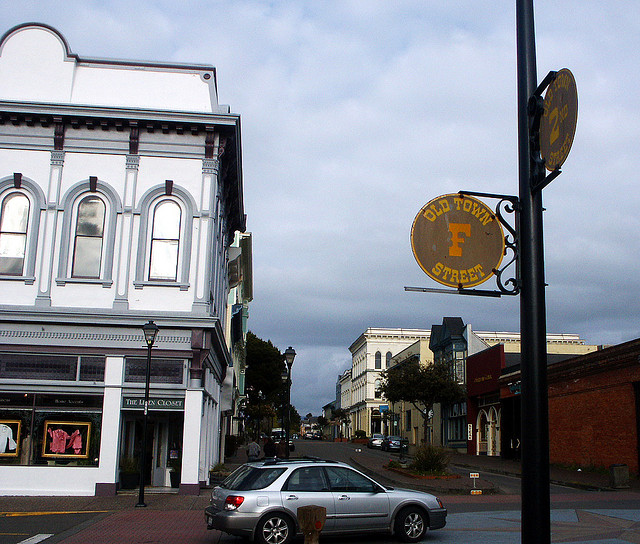

In [51]:
import time
test_image = './test_images/000000001924.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

# real_caption = final_cap_test[rid]
real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
# real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

Image.open(test_image)

### 